In [ ]:
# ============================================================
# 📌 Defense Module – Environment Setup (New Notebook)
# ============================================================

!pip install torch torchvision foolbox==3.3.3 --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# -------------------------------------
# 🔹 Step 1: Mount Google Drive
# -------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------------------
# 🔹 Step 2: Set device
# -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------------
# 🔹 Step 3: CIFAR-10 Normalization
# -------------------------------------
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_set = datasets.CIFAR10(root="/content/data", train=False, download=True,
                            transform=transform_test)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# -------------------------------------
# 🔹 Step 4: Load your previously saved robust model
# -------------------------------------

MODEL_PATH = "/content/drive/MyDrive/AI_Security_Red_Team_Toolkit/Checkpoints"



# Define your model architecture again (same as training)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Load the model
robust_model = SimpleCNN().to(device)

if os.path.exists(MODEL_PATH):
    robust_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    robust_model.eval()
    print("✅ Robust model loaded successfully!")
else:
    print("❌ Model file not found:", MODEL_PATH)

print("\nEnvironment is ready. Begin Defensive Distillation next!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.5 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 39.9MB/s]


❌ Model file not found: /content/drive/MyDrive/AI_Security_Red_Team_Toolkit/Checkpoints

Environment is ready. Begin Defensive Distillation next!


In [ ]:
# ============================================================
# 📌 FIX: DOWNLOAD MODEL FROM DRIVE ID
# ============================================================

!pip install gdown --quiet

# The File ID for your saved robust model
FILE_ID = '1nxIGI6UT1nYCr52SrBO64F2XFCjcYSQv'

# Define the local path where we will save the model weights
MODEL_FILE_NAME = 'best_clean_robust_resnet18_cifar10.pth'
LOCAL_MODEL_PATH = f'/content/{MODEL_FILE_NAME}'

print(f"Downloading model file to {LOCAL_MODEL_PATH}...")

# Use gdown to download the file directly
# NOTE: Ensure the file permission is set to "Anyone with the link" in your Drive.
!gdown --id {FILE_ID} -O {LOCAL_MODEL_PATH}

print("✅ Download complete. Model is ready to be loaded.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1nxIGI6UT1nYCr52SrBO64F2XFCjcYSQv
From (redirected): https://drive.google.com/uc?id=1nxIGI6UT1nYCr52SrBO64F2XFCjcYSQv&confirm=t&uuid=515f6c7c-34f5-4cb1-b418-c26f9795a438
To: /content/best_clean_robust_resnet18_cifar10.pth
100% 89.6M/89.6M [00:01<00:00, 76.7MB/s]
✅ Download complete. Model is ready to be loaded.


In [ ]:
# ============================================================
# 📌 FIXED: Load torchvision ResNet18 trained on CIFAR-10
# ============================================================
import torchvision.models as models

MODEL_PATH = "/content/best_clean_robust_resnet18_cifar10.pth"

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
print("Checkpoint keys:", checkpoint.keys())

# Create torchvision ResNet18
robust_model = models.resnet18(weights=None)
robust_model.fc = torch.nn.Linear(512, 10)  # CIFAR-10 head
robust_model = robust_model.to(device)

# Extract ONLY the model weights from checkpoint
state_dict = checkpoint["model_state_dict"]

# Load weights
robust_model.load_state_dict(state_dict, strict=True)
robust_model.eval()

print("✅ Successfully loaded torchvision ResNet18 model!")


Checkpoint keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'clean_acc', 'robust_acc'])
✅ Successfully loaded torchvision ResNet18 model!


In [ ]:
# ============================================================
# 🎯 Defensive Distillation: Teacher & Student Setup
# ============================================================

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# ------------------------------------------------------------
# 🔹 Teacher model (already loaded as robust_model)
# ------------------------------------------------------------
teacher_model = robust_model
teacher_model.eval()  # Freeze teacher
for p in teacher_model.parameters():
    p.requires_grad = False

print("📌 Teacher model ready (frozen).")

# ------------------------------------------------------------
# 🔹 Distillation Temperature (T)
# ------------------------------------------------------------
T = 20  # You can change later if needed
print(f"📌 Temperature for distillation: T = {T}")

# ------------------------------------------------------------
# 🔹 Student model: same architecture (ResNet18 for CIFAR-10)
# ------------------------------------------------------------
student_model = models.resnet18(weights=None)
student_model.fc = nn.Linear(512, 10)
student_model = student_model.to(device)

print("📌 Student model initialized.")

# ------------------------------------------------------------
# 🔹 Knowledge Distillation Loss Function
# ------------------------------------------------------------
def distillation_loss(student_logits, teacher_logits, T):
    """
    KL divergence between teacher soft targets and student predictions.
    """
    teacher_probs = F.softmax(teacher_logits / T, dim=1)
    student_log_probs = F.log_softmax(student_logits / T, dim=1)
    loss_KL = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (T * T)
    return loss_KL

print("📌 Distillation loss function ready.")


📌 Teacher model ready (frozen).
📌 Temperature for distillation: T = 20
📌 Student model initialized.
📌 Distillation loss function ready.


In [ ]:
# ============================================================
# 📦 CIFAR-10 Data Loading (for distillation training)
# ============================================================

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ------------------------------------------------------------
# 🔹 CIFAR-10 Normalization (same as teacher model)
# ------------------------------------------------------------
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# ------------------------------------------------------------
# 🔹 Load CIFAR-10
# ------------------------------------------------------------
train_dataset = torchvision.datasets.CIFAR10(
    root="/content/data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="/content/data",
    train=False,
    download=True,
    transform=transform_test
)

# ------------------------------------------------------------
# 🔹 Data Loaders
# ------------------------------------------------------------
batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

print("📌 CIFAR-10 Data Loaders Ready:")
print(f"   ➤ Train batches: {len(train_loader)}")
print(f"   ➤ Test batches : {len(test_loader)}")


📌 CIFAR-10 Data Loaders Ready:
   ➤ Train batches: 391
   ➤ Test batches : 79


In [ ]:
# ============================================================
# 🚀 Defensive Distillation Training Loop
# ============================================================

epochs = 10
learning_rate = 0.001

optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

print("🔧 Starting distillation training...")

for epoch in range(epochs):
    student_model.train()
    running_loss = 0.0
    total, correct = 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # -----------------------------
        # 1️⃣ Teacher forward pass
        # -----------------------------
        with torch.no_grad():
            teacher_logits = teacher_model(x)

        # -----------------------------
        # 2️⃣ Student forward pass
        # -----------------------------
        student_logits = student_model(x)

        # -----------------------------
        # 3️⃣ Distillation loss
        # -----------------------------
        loss = distillation_loss(student_logits, teacher_logits, T)

        # -----------------------------
        # 4️⃣ Backward & optimize
        # -----------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # -----------------------------
        # 5️⃣ Track accuracy (student)
        # -----------------------------
        _, predicted = student_logits.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    print(f"📘 Epoch [{epoch+1}/{epochs}]  "
          f"Loss: {epoch_loss:.4f}  |  Student Clean Acc: {epoch_acc:.2f}%")

print("✅ Distillation training completed!")

# ============================================================
# 💾 Save distilled student model
# ============================================================

SAVE_PATH = "/content/distilled_resnet18_cifar10.pth"
torch.save({
    "student_state_dict": student_model.state_dict(),
    "temperature": T
}, SAVE_PATH)

print(f"💾 Saved distilled student model to: {SAVE_PATH}")


🔧 Starting distillation training...
📘 Epoch [1/10]  Loss: 0.4621  |  Student Clean Acc: 46.32%
📘 Epoch [2/10]  Loss: 0.2195  |  Student Clean Acc: 56.06%
📘 Epoch [3/10]  Loss: 0.1596  |  Student Clean Acc: 59.79%
📘 Epoch [4/10]  Loss: 0.1316  |  Student Clean Acc: 61.70%
📘 Epoch [5/10]  Loss: 0.1133  |  Student Clean Acc: 62.79%
📘 Epoch [6/10]  Loss: 0.1030  |  Student Clean Acc: 63.49%
📘 Epoch [7/10]  Loss: 0.0933  |  Student Clean Acc: 64.40%
📘 Epoch [8/10]  Loss: 0.0857  |  Student Clean Acc: 64.39%
📘 Epoch [9/10]  Loss: 0.0844  |  Student Clean Acc: 64.98%
📘 Epoch [10/10]  Loss: 0.0826  |  Student Clean Acc: 65.37%
✅ Distillation training completed!
💾 Saved distilled student model to: /content/distilled_resnet18_cifar10.pth


In [ ]:
import os
import shutil

# --- Define Paths ---
# Local file path
LOCAL_FILE_PATH = "/content/distilled_resnet18_cifar10.pth"

# Drive destination folder (using the established backup path)
DRIVE_BACKUP_DIR = '/content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses'
DRIVE_FILE_PATH = os.path.join(DRIVE_BACKUP_DIR, "distilled_resnet18_cifar10.pth")

print(f"Creating Drive destination folder: {DRIVE_BACKUP_DIR}")
os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

print("Copying Distilled Model to Google Drive...")

# Copy the file
shutil.copyfile(LOCAL_FILE_PATH, DRIVE_FILE_PATH)

print(f"\n✅ Distilled model successfully saved to Drive: {DRIVE_FILE_PATH}")

Creating Drive destination folder: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses
Copying Distilled Model to Google Drive...

✅ Distilled model successfully saved to Drive: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/distilled_resnet18_cifar10.pth


In [ ]:
# ============================================================
# 📊 Evaluate Distilled Student Model (Clean Accuracy)
# ============================================================

import torch.nn.functional as F

# Load distilled weights (already trained)
loaded_ckpt = torch.load("/content/distilled_resnet18_cifar10.pth", map_location=device)

student_model = models.resnet18(weights=None)
student_model.fc = nn.Linear(512, 10)
student_model.load_state_dict(loaded_ckpt["student_state_dict"])
student_model = student_model.to(device)
student_model.eval()

print("📌 Loaded distilled student model for evaluation.")

correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        logits = student_model(x)
        _, predicted = logits.max(1)

        total += y.size(0)
        correct += predicted.eq(y).sum().item()

clean_acc = 100.0 * correct / total
print(f"🎯 Distilled Student Clean Test Accuracy: {clean_acc:.2f}%")


📌 Loaded distilled student model for evaluation.
🎯 Distilled Student Clean Test Accuracy: 64.14%


In [ ]:
import foolbox as fb

# Make sure models are in eval mode
teacher_model.eval()
student_model.eval()

# Wrap for Foolbox (bounds=[0,1] because CIFAR-10 images are normalized manually)
fmodel_teacher = fb.PyTorchModel(teacher_model, bounds=(0, 1), device=device)
fmodel_student = fb.PyTorchModel(student_model, bounds=(0, 1), device=device)


In [ ]:
from foolbox.attacks import FGSM

epsilon = 0.03  # Perturbation size

attack = FGSM()


In [ ]:
def evaluate_attack(fmodel, data_loader, attack, epsilons):
    correct = 0
    total = 0
    adv_success = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        # Unnormalize to [0,1] for Foolbox if needed
        x_unnorm = x * torch.tensor([0.2023,0.1994,0.2010]).view(3,1,1).to(device) + \
                   torch.tensor([0.4914,0.4822,0.4465]).view(3,1,1).to(device)
        x_unnorm = torch.clamp(x_unnorm, 0, 1)

        # Run attack
        advs, _, success = attack(fmodel, x_unnorm, y, epsilons=epsilons)

        # Compute clean accuracy
        logits = fmodel(x_unnorm)
        _, predicted = logits.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)

        # Compute attack success
        adv_success += success.sum().item()

    clean_acc = 100.0 * correct / total
    adv_acc = 100.0 * (total - adv_success) / total
    return clean_acc, adv_acc

epsilons = [epsilon]

teacher_clean, teacher_adv = evaluate_attack(fmodel_teacher, test_loader, attack, epsilons)
student_clean, student_adv = evaluate_attack(fmodel_student, test_loader, attack, epsilons)

print(f"📌 Teacher Model | Clean Acc: {teacher_clean:.2f}% | FGSM Robust Acc: {teacher_adv:.2f}%")
print(f"📌 Student Model | Clean Acc: {student_clean:.2f}% | FGSM Robust Acc: {student_adv:.2f}%")


📌 Teacher Model | Clean Acc: 20.57% | FGSM Robust Acc: 15.42%
📌 Student Model | Clean Acc: 18.26% | FGSM Robust Acc: 12.66%


In [ ]:
# Since epsilons=[epsilon], advs is a list with one element
advs_tensor = advs[0]  # shape: [batch_size, 3, 32, 32]

for i in range(5):
    save_image(x_unnorm[i], f"adv_examples/orig_{i}.png")
    save_image(advs_tensor[i], f"adv_examples/adv_{i}.png")
    save_image((advs_tensor[i] - x_unnorm[i]) * 10, f"adv_examples/diff_{i}.png")


In [ ]:
# ============================================================
# 📸 Save Adversarial Examples (Corrected Foolbox Indexing)
# ============================================================

from torchvision.utils import save_image
import os

# Folder for adversarial samples
os.makedirs("adv_examples", exist_ok=True)

# Take one batch from test loader
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

# Unnormalize to [0,1]
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(device)
std  = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1).to(device)

x_unnorm = x * std + mean
x_unnorm = torch.clamp(x_unnorm, 0, 1)

# Generate FGSM adversarial samples
advs, _, success = attack(fmodel_student, x_unnorm, y, epsilons=[epsilon])

# Since epsilons=[0.03], adversarial samples are in advs[0]
advs = advs[0]

print("Saving first 5 adversarial samples...")

for i in range(5):

    save_image(x_unnorm[i], f"adv_examples/orig_{i}.png")
    save_image(advs[i],     f"adv_examples/adv_{i}.png")

    # amplified difference for visibility
    diff = (advs[i] - x_unnorm[i]) * 10
    diff = torch.clamp(diff, 0, 1)

    save_image(diff, f"adv_examples/diff_{i}.png")

print("✅ Saved: orig_i.png, adv_i.png, diff_i.png in adv_examples/")


Saving first 5 adversarial samples...
✅ Saved: orig_i.png, adv_i.png, diff_i.png in adv_examples/


In [ ]:
import os
import shutil

# --- Define Paths ---
LOCAL_SAMPLES_DIR = "/content/adv_examples"
DRIVE_BACKUP_DIR = '/content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_Distilled_FGSM'

print(f"Creating Drive destination folder: {DRIVE_BACKUP_DIR}")
os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

print(f"Copying adversarial examples from local storage to Google Drive: {LOCAL_SAMPLES_DIR} -> {DRIVE_BACKUP_DIR}")

# Copy the entire directory content recursively
# The shell command automatically handles directory contents.
!cp -r "{LOCAL_SAMPLES_DIR}"/* "{DRIVE_BACKUP_DIR}"

print("\n✅ Adversarial examples successfully saved to Google Drive!")

Creating Drive destination folder: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_Distilled_FGSM
Copying adversarial examples from local storage to Google Drive: /content/adv_examples -> /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_Distilled_FGSM

✅ Adversarial examples successfully saved to Google Drive!


In [ ]:
# ============================================================
# 🚀 Combined Adversarial Training: FGSM + PGD
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Student model for adversarial training
adv_student = models.resnet18(weights=None)
adv_student.fc = nn.Linear(512, 10)
adv_student = adv_student.to(device)

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(adv_student.parameters(), lr=learning_rate)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training parameters
epochs = 5  # Can increase if needed
epsilon_fgsm = 0.03
epsilon_pgd = 0.03
pgd_steps = 7
alpha = 0.007  # step size for PGD

print("🔧 Starting combined adversarial training...")

for epoch in range(epochs):
    adv_student.train()
    running_loss = 0.0
    total, correct = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)

        # -----------------------------
        # 1️⃣ Generate FGSM adversarial samples
        # -----------------------------
        x.requires_grad = True
        logits = adv_student(x)
        loss = criterion(logits, y)
        adv_student.zero_grad()
        loss.backward()
        x_fgsm = x + epsilon_fgsm * x.grad.sign()
        x_fgsm = torch.clamp(x_fgsm, 0, 1)

        # -----------------------------
        # 2️⃣ Generate PGD adversarial samples
        # -----------------------------
        x_pgd = x.clone().detach()
        x_pgd.requires_grad = True
        for _ in range(pgd_steps):
            logits_pgd = adv_student(x_pgd)
            loss_pgd = criterion(logits_pgd, y)
            adv_student.zero_grad()
            loss_pgd.backward()
            x_pgd = x_pgd + alpha * x_pgd.grad.sign()
            # Project back to epsilon-ball around original image
            x_pgd = torch.max(torch.min(x_pgd, x + epsilon_pgd), x - epsilon_pgd)
            x_pgd = torch.clamp(x_pgd, 0, 1)
            x_pgd = x_pgd.detach().requires_grad_()

        # -----------------------------
        # 3️⃣ Forward pass on clean + adversarial
        # -----------------------------
        logits_clean = adv_student(x)
        logits_fgsm = adv_student(x_fgsm)
        logits_pgd = adv_student(x_pgd)

        # -----------------------------
        # 4️⃣ Combined loss
        # -----------------------------
        loss_combined = (criterion(logits_clean, y) +
                         criterion(logits_fgsm, y) +
                         criterion(logits_pgd, y)) / 3.0

        optimizer.zero_grad()
        loss_combined.backward()
        optimizer.step()

        running_loss += loss_combined.item()
        _, predicted = logits_clean.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    print(f"📘 Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Clean Acc: {epoch_acc:.2f}%")

print("✅ Combined adversarial training completed!")

# ============================================================
# 💾 Save adversarially trained student model
# ============================================================
SAVE_PATH_ADV = "/content/adv_trained_student_resnet18.pth"
torch.save({
    "student_state_dict": adv_student.state_dict(),
    "epochs": epochs
}, SAVE_PATH_ADV)

print(f"💾 Adversarially trained student model saved at: {SAVE_PATH_ADV}")


🔧 Starting combined adversarial training...


Epoch 1/5: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


📘 Epoch [1/5]  Loss: 1.7632  Clean Acc: 39.99%


Epoch 2/5: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


📘 Epoch [2/5]  Loss: 1.4749  Clean Acc: 53.98%


Epoch 3/5: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


📘 Epoch [3/5]  Loss: 1.3337  Clean Acc: 60.67%


Epoch 4/5: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


📘 Epoch [4/5]  Loss: 1.2404  Clean Acc: 65.00%


Epoch 5/5: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

📘 Epoch [5/5]  Loss: 1.1726  Clean Acc: 68.35%
✅ Combined adversarial training completed!
💾 Adversarially trained student model saved at: /content/adv_trained_student_resnet18.pth


In [ ]:
import os
import shutil

# --- Define Paths ---
LOCAL_FILE_PATH = "/content/adv_trained_student_resnet18.pth"
DRIVE_BACKUP_DIR = '/content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses'
DRIVE_FILE_PATH = os.path.join(DRIVE_BACKUP_DIR, "adv_trained_student_resnet18.pth")

print(f"Ensuring Drive destination folder exists: {DRIVE_BACKUP_DIR}")
os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

print("Copying Adversarially Trained Model to Google Drive...")

# Copy the file
shutil.copyfile(LOCAL_FILE_PATH, DRIVE_FILE_PATH)

print(f"\n✅ Adversarially trained model successfully saved to Drive: {DRIVE_FILE_PATH}")

Ensuring Drive destination folder exists: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses
Copying Adversarially Trained Model to Google Drive...

✅ Adversarially trained model successfully saved to Drive: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/adv_trained_student_resnet18.pth


In [ ]:
# ============================================================
# 📊 Evaluate Adversarially Trained Student Model (Strong Attack)
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from tqdm import tqdm
import foolbox as fb
from foolbox.attacks import FGSM, PGD
from torchvision.utils import save_image
import os

# -----------------------------
# 🔹 Load adversarially trained student
# -----------------------------
adv_student = models.resnet18(weights=None)
adv_student.fc = nn.Linear(512, 10)
checkpoint_adv = torch.load("/content/adv_trained_student_resnet18.pth", map_location=device)
adv_student.load_state_dict(checkpoint_adv["student_state_dict"])
adv_student = adv_student.to(device)
adv_student.eval()
print("📌 Adversarially trained student model loaded.")

# -----------------------------
# 🔹 Wrap models for Foolbox
# -----------------------------
fmodel_adv = fb.PyTorchModel(adv_student, bounds=(0,1), device=device)

# -----------------------------
# 🔹 Adversarial attacks (stronger)
# -----------------------------
epsilon_fgsm = 0.08
epsilon_pgd  = 0.08
pgd_steps    = 20
alpha        = 0.01

attack_fgsm = FGSM()
attack_pgd  = PGD(steps=pgd_steps, rel_stepsize=alpha/epsilon_pgd)

# -----------------------------
# 🔹 Evaluation function
# -----------------------------
def evaluate_attack(fmodel, data_loader, attack, epsilons):
    correct = 0
    total = 0
    adv_success = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        # Unnormalize to [0,1]
        mean = torch.tensor([0.4914,0.4822,0.4465]).view(3,1,1).to(device)
        std  = torch.tensor([0.2023,0.1994,0.2010]).view(3,1,1).to(device)
        x_unnorm = torch.clamp(x * std + mean, 0, 1)

        # Run attack
        advs, _, success = attack(fmodel, x_unnorm, y, epsilons=epsilons)

        # Clean accuracy
        logits = fmodel(x_unnorm)
        _, predicted = logits.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)

        # Attack success
        adv_success += success.sum().item()

    clean_acc = 100.0 * correct / total
    adv_acc   = 100.0 * (total - adv_success) / total
    return clean_acc, adv_acc

# -----------------------------
# 🔹 Run evaluation
# -----------------------------
teacher_clean, teacher_adv = evaluate_attack(fmodel_teacher, test_loader, attack_fgsm, epsilons=[epsilon_fgsm])
student_clean, student_adv = evaluate_attack(fmodel_student, test_loader, attack_fgsm, epsilons=[epsilon_fgsm])
adv_clean,     adv_adv     = evaluate_attack(fmodel_adv, test_loader, attack_fgsm, epsilons=[epsilon_fgsm])

print(f"📌 FGSM (ε={epsilon_fgsm}) Evaluation:")
print(f"Teacher Model Clean: {teacher_clean:.2f}% | Robust: {teacher_adv:.2f}%")
print(f"Distilled Student Clean: {student_clean:.2f}% | Robust: {student_adv:.2f}%")
print(f"Adversarially Trained Student Clean: {adv_clean:.2f}% | Robust: {adv_adv:.2f}%")

# -----------------------------
# 🔹 Save 5 adversarial examples for FGSM
# -----------------------------
os.makedirs("adv_examples_fgsm", exist_ok=True)
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
mean = torch.tensor([0.4914,0.4822,0.4465]).view(3,1,1).to(device)
std  = torch.tensor([0.2023,0.1994,0.2010]).view(3,1,1).to(device)
x_unnorm = torch.clamp(x*std + mean, 0, 1)
advs, _, _ = attack_fgsm(fmodel_adv, x_unnorm, y, epsilons=[epsilon_fgsm])
advs = advs[0]  # single epsilon

for i in range(5):
    save_image(x_unnorm[i], f"adv_examples_fgsm/orig_{i}.png")
    save_image(advs[i],     f"adv_examples_fgsm/adv_{i}.png")
    diff = torch.clamp((advs[i]-x_unnorm[i])*10,0,1)
    save_image(diff, f"adv_examples_fgsm/diff_{i}.png")

print("✅ Saved first 5 FGSM adversarial examples in adv_examples_fgsm/")


📌 Adversarially trained student model loaded.
📌 FGSM (ε=0.08) Evaluation:
Teacher Model Clean: 20.57% | Robust: 8.54%
Distilled Student Clean: 18.26% | Robust: 7.62%
Adversarially Trained Student Clean: 26.89% | Robust: 0.76%
✅ Saved first 5 FGSM adversarial examples in adv_examples_fgsm/


In [ ]:
import os
import shutil

# --- Define Paths ---
LOCAL_SAMPLES_DIR = "/content/adv_examples_fgsm"
DRIVE_BACKUP_DIR = '/content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_AdvTrained_FGSM'

print(f"Creating Drive destination folder: {DRIVE_BACKUP_DIR}")
os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

print(f"Copying adversarial examples from local storage to Google Drive: {LOCAL_SAMPLES_DIR}")

# Copy the entire directory content recursively
!cp -r "{LOCAL_SAMPLES_DIR}"/* "{DRIVE_BACKUP_DIR}"

print("\n✅ FGSM adversarial examples successfully saved to Google Drive!")

Creating Drive destination folder: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_AdvTrained_FGSM
Copying adversarial examples from local storage to Google Drive: /content/adv_examples_fgsm

✅ FGSM adversarial examples successfully saved to Google Drive!


In [ ]:
# ============================================================
# 📊 PGD Adversarial Evaluation (ε=0.08, steps=20, α=0.01)
# ============================================================

# PGD attack
attack_pgd = PGD(steps=20, rel_stepsize=0.01/0.08)  # α / ε

# Evaluate PGD robustness
teacher_clean_pgd, teacher_adv_pgd = evaluate_attack(fmodel_teacher, test_loader, attack_pgd, epsilons=[0.08])
student_clean_pgd, student_adv_pgd = evaluate_attack(fmodel_student, test_loader, attack_pgd, epsilons=[0.08])
adv_clean_pgd, adv_adv_pgd         = evaluate_attack(fmodel_adv, test_loader, attack_pgd, epsilons=[0.08])

print(f"📌 PGD (ε=0.08, steps=20) Evaluation:")
print(f"Teacher Model Clean: {teacher_clean_pgd:.2f}% | Robust: {teacher_adv_pgd:.2f}%")
print(f"Distilled Student Clean: {student_clean_pgd:.2f}% | Robust: {student_adv_pgd:.2f}%")
print(f"Adversarially Trained Student Clean: {adv_clean_pgd:.2f}% | Robust: {adv_adv_pgd:.2f}%")

# Save first 5 PGD adversarial examples for adversarially trained student
os.makedirs("adv_examples_pgd", exist_ok=True)
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
mean = torch.tensor([0.4914,0.4822,0.4465]).view(3,1,1).to(device)
std  = torch.tensor([0.2023,0.1994,0.2010]).view(3,1,1).to(device)
x_unnorm = torch.clamp(x*std + mean, 0, 1)
advs, _, _ = attack_pgd(fmodel_adv, x_unnorm, y, epsilons=[0.08])
advs = advs[0]

for i in range(5):
    save_image(x_unnorm[i], f"adv_examples_pgd/orig_{i}.png")
    save_image(advs[i],     f"adv_examples_pgd/adv_{i}.png")
    diff = torch.clamp((advs[i]-x_unnorm[i])*10,0,1)
    save_image(diff, f"adv_examples_pgd/diff_{i}.png")

print("✅ Saved first 5 PGD adversarial examples in adv_examples_pgd/")


📌 PGD (ε=0.08, steps=20) Evaluation:
Teacher Model Clean: 20.57% | Robust: 5.83%
Distilled Student Clean: 18.26% | Robust: 4.94%
Adversarially Trained Student Clean: 26.89% | Robust: 0.02%
✅ Saved first 5 PGD adversarial examples in adv_examples_pgd/


In [ ]:
import os
import shutil

# --- Define Paths ---
LOCAL_SAMPLES_DIR = "/content/adv_examples_pgd"
DRIVE_BACKUP_DIR = '/content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_AdvTrained_PGD'

print(f"Creating Drive destination folder: {DRIVE_BACKUP_DIR}")
os.makedirs(DRIVE_BACKUP_DIR, exist_ok=True)

print(f"Copying PGD adversarial examples from local storage to Google Drive: {LOCAL_SAMPLES_DIR}")

# Copy the entire directory content recursively
!cp -r "{LOCAL_SAMPLES_DIR}"/* "{DRIVE_BACKUP_DIR}"

print("\n✅ PGD adversarial examples successfully saved to Google Drive!")

Creating Drive destination folder: /content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses/Adv_Examples_AdvTrained_PGD
Copying PGD adversarial examples from local storage to Google Drive: /content/adv_examples_pgd

✅ PGD adversarial examples successfully saved to Google Drive!


In [2]:
# ============================================================
# 🚀 Full Interactive Dashboard for CIFAR-10 Adversarial Project
# ============================================================

!pip install gradio --quiet
import gradio as gr
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torchvision.utils import save_image

# -----------------------------
# 🔹 Models already trained
# -----------------------------
# Teacher, Distilled Student, Adversarial Student
teacher_model.eval()
student_model.eval()
adv_student.eval()

# Wrap Foolbox models for attacks
import foolbox as fb
from foolbox.attacks import FGSM, PGD

fmodel_teacher = fb.PyTorchModel(teacher_model, bounds=(0,1), device=device)
fmodel_student = fb.PyTorchModel(student_model, bounds=(0,1), device=device)
fmodel_adv = fb.PyTorchModel(adv_student, bounds=(0,1), device=device)

# -----------------------------
# 🔹 CIFAR-10 label names
# -----------------------------
classes = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# -----------------------------
# 🔹 Normalization / unnormalization
# -----------------------------
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(device)
std  = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1).to(device)

def preprocess_image(img: Image):
    """Convert PIL image to normalized torch tensor for CIFAR-10"""
    img = img.resize((32,32))
    img = transforms.ToTensor()(img)
    img = (img - mean)/std
    img = img.unsqueeze(0).to(device)
    return img

def unnormalize_tensor(tensor):
    return torch.clamp(tensor * std + mean, 0, 1)

# -----------------------------
# 🔹 Attack function
# -----------------------------
def generate_adversarial(model_type, attack_type, epsilon, img):
    # Select model
    if model_type=="Teacher":
        model = teacher_model
        fmodel = fmodel_teacher
    elif model_type=="Distilled":
        model = student_model
        fmodel = fmodel_student
    else:
        model = adv_student
        fmodel = fmodel_adv

    # Preprocess
    x = preprocess_image(img)
    y = torch.tensor([0]).to(device)  # dummy, will use model argmax
    with torch.no_grad():
        logits = model(x)
        y_label = logits.argmax(dim=1)

    # Apply attack
    if attack_type=="None":
        adv_x = x
    elif attack_type=="FGSM":
        attack = FGSM()
        adv_x, _, _ = attack(fmodel, x, y_label, epsilons=[epsilon])
        adv_x = adv_x[0]
    else:  # PGD
        attack = PGD(steps=20, rel_stepsize=0.01/epsilon)
        adv_x, _, _ = attack(fmodel, x, y_label, epsilons=[epsilon])
        adv_x = adv_x[0]

    # Predictions
    with torch.no_grad():
        logits_clean = model(x)
        logits_adv   = model(adv_x)
        pred_clean = classes[logits_clean.argmax(1).item()]
        pred_adv   = classes[logits_adv.argmax(1).item()]

    # Prepare images for display
    img_orig = unnormalize_tensor(x.squeeze()).cpu()
    img_adv  = unnormalize_tensor(adv_x.squeeze()).cpu()
    img_diff = torch.clamp((img_adv - img_orig)*10,0,1)

    return img_orig, img_adv, img_diff, pred_clean, pred_adv

# -----------------------------
# 🔹 Gradio interface
# -----------------------------
iface = gr.Interface(
    fn=generate_adversarial,
    inputs=[
        gr.Dropdown(["Teacher","Distilled","Adversarial"], label="Select Model"),
        gr.Dropdown(["None","FGSM","PGD"], label="Select Attack"),
        gr.Slider(0.01, 0.1, 0.01, value=0.03, label="Epsilon"),
        gr.Image(type="pil", label="Upload Image (32x32 or any)")
    ],
    outputs=[
        gr.Image(type="numpy", label="Original Image"),
        gr.Image(type="numpy", label="Adversarial Image"),
        gr.Image(type="numpy", label="Amplified Difference (x10)"),
        gr.Textbox(label="Original Prediction"),
        gr.Textbox(label="Adversarial Prediction")
    ],
    title="CIFAR-10 Adversarial Defense Dashboard",
    description="Demo Teacher / Distilled / Adversarial models with FGSM/PGD attacks",
    live=True
)

iface.launch()


NameError: name 'teacher_model' is not defined

In [ ]:
# ============================================================
# 🎯 FINAL CORRECTED ROBUSTNESS REPORT
# ============================================================

import torch.nn.functional as F
from tabulate import tabulate
import foolbox as fb
from foolbox.attacks import FGSM, PGD

# --- Setup for Corrected Evaluation ---
# Ensure the following are defined/loaded in your Colab session:
# teacher_model, student_model, adv_student, fmodel_teacher, fmodel_student, fmodel_adv
# test_loader, device
# PGD_ATTACK, FGSM_ATTACK (using strong parameters: epsilon=0.08)

# Global normalization constants
mean_tensor = torch.tensor((0.4914, 0.4822, 0.4465)).view(3, 1, 1).to(device)
std_tensor  = torch.tensor((0.2023, 0.1994, 0.2010)).view(3, 1, 1).to(device)
PGD_EPSILON = [0.08]
FGSM_EPSILON = [0.08]
NUM_SAMPLES = 1000

# PGD Attack (Strong)
PGD_ATTACK_STRONG = PGD(steps=20, rel_stepsize=0.01/0.08)
FGSM_ATTACK_STRONG = FGSM()

def evaluate_robustness_corrected(model, fmodel, data_loader, attack, epsilons, num_samples):
    """Correctly evaluates Clean (normalized) and Robust (normalized adv) Accuracy."""

    correct_clean, correct_adv, total = 0, 0, 0

    for x, y in data_loader:
        if total >= num_samples: break

        x, y = x.to(device), y.to(device) # x is NORMALISED

        # 1. Clean Accuracy (using NORMALISED input 'x')
        with torch.no_grad():
            correct_clean += model(x).argmax(1).eq(y).sum().item()

        # 2. Attack (needs UNNORMALISED input, returns UNNORMALISED adv)
        x_unnorm = torch.clamp(x * std_tensor + mean_tensor, 0, 1)
        advs_list, _, _ = attack(fmodel, x_unnorm, y, epsilons=epsilons)

        if advs_list and len(advs_list) > 0:
            advs = advs_list[0]
            # 3. Robust Accuracy (on NORMALISED adversarial input)
            advs_norm = (advs - mean_tensor) / std_tensor
            with torch.no_grad():
                correct_adv += model(advs_norm).argmax(1).eq(y).sum().item()

        total += y.size(0)

    clean_acc = 100.0 * correct_clean / total
    robust_acc = 100.0 * correct_adv / total
    return clean_acc, robust_acc

print("Starting Final Corrected Evaluation...")

# 1. Teacher Model (PGD-AT)
teacher_clean_pgd, teacher_robust_pgd = evaluate_robustness_corrected(
    teacher_model, fmodel_teacher, test_loader, PGD_ATTACK_STRONG, PGD_EPSILON, NUM_SAMPLES)
_, teacher_robust_fgsm = evaluate_robustness_corrected(
    teacher_model, fmodel_teacher, test_loader, FGSM_ATTACK_STRONG, FGSM_EPSILON, NUM_SAMPLES)

# 2. Distilled Student
student_clean_pgd, student_robust_pgd = evaluate_robustness_corrected(
    student_model, fmodel_student, test_loader, PGD_ATTACK_STRONG, PGD_EPSILON, NUM_SAMPLES)
_, student_robust_fgsm = evaluate_robustness_corrected(
    student_model, fmodel_student, test_loader, FGSM_ATTACK_STRONG, FGSM_EPSILON, NUM_SAMPLES)

# 3. Adv-Trained Student
adv_clean_pgd, adv_robust_pgd = evaluate_robustness_corrected(
    adv_student, fmodel_adv, test_loader, PGD_ATTACK_STRONG, PGD_EPSILON, NUM_SAMPLES)
_, adv_robust_fgsm = evaluate_robustness_corrected(
    adv_student, fmodel_adv, test_loader, FGSM_ATTACK_STRONG, FGSM_EPSILON, NUM_SAMPLES)


# --- Final Report ---
data_final = [
    ["Teacher Model (PGD-AT)", f"{teacher_clean_pgd:.2f}%", f"{teacher_robust_fgsm:.2f}%", f"{teacher_robust_pgd:.2f}%"],
    ["Distilled Student", f"{student_clean_pgd:.2f}%", f"{student_robust_fgsm:.2f}%", f"{student_robust_pgd:.2f}%"],
    ["Adv-Trained Student", f"{adv_clean_pgd:.2f}%", f"{adv_robust_fgsm:.2f}%", f"{adv_robust_pgd:.2f}%"],
]

print("\n=====================================================================")
print("⭐ FINAL PROJECT ROBUSTNESS REPORT (CORRECTED METRICS) ⭐")
print("=====================================================================")
print(tabulate(data_final, headers=["Model", "Clean Acc", "FGSM Acc (ε=0.08)", "PGD Acc (ε=0.08, 20 steps)"], tablefmt="fancy_grid"))

Starting Final Corrected Evaluation...

⭐ FINAL PROJECT ROBUSTNESS REPORT (CORRECTED METRICS) ⭐
╒════════════════════════╤═════════════╤═════════════════════╤══════════════════════════════╕
│ Model                  │ Clean Acc   │ FGSM Acc (ε=0.08)   │ PGD Acc (ε=0.08, 20 steps)   │
╞════════════════════════╪═════════════╪═════════════════════╪══════════════════════════════╡
│ Teacher Model (PGD-AT) │ 70.21%      │ 42.38%              │ 36.23%                       │
├────────────────────────┼─────────────┼─────────────────────┼──────────────────────────────┤
│ Distilled Student      │ 66.41%      │ 34.38%              │ 27.25%                       │
├────────────────────────┼─────────────┼─────────────────────┼──────────────────────────────┤
│ Adv-Trained Student    │ 59.86%      │ 9.38%               │ 5.27%                        │
╘════════════════════════╧═════════════╧═════════════════════╧══════════════════════════════╛


In [1]:
# 🔹 Attack function (CORRECTED)
def generate_adversarial(model_type, attack_type, epsilon, img):
    # Select model
    if model_type=="Teacher":
        model = teacher_model
        fmodel = fmodel_teacher
    elif model_type=="Distilled":
        model = student_model
        fmodel = fmodel_student
    else:
        model = adv_student
        fmodel = fmodel_adv

    # Preprocess (Input 'x' is NORMALISED)
    x = preprocess_image(img)
    y = torch.tensor([0]).to(device)  # dummy, will use model argmax

    # 1. Prediction on CLEAN NORMALISED image
    with torch.no_grad():
        logits_clean = model(x)
        y_label = logits_clean.argmax(dim=1)
        pred_clean = classes[y_label.item()]

    # 2. Prepare UNNORMALISED input for Foolbox attack
    x_unnorm = unnormalize_tensor(x.squeeze()).unsqueeze(0).to(device) # Shape [1, 3, 32, 32]

    # Apply attack
    if attack_type=="None":
        adv_x_unnorm = x_unnorm
    elif attack_type=="FGSM":
        attack = FGSM()
        advs_list, _, _ = attack(fmodel, x_unnorm, y_label, epsilons=[epsilon])
        adv_x_unnorm = advs_list[0] if advs_list and len(advs_list) > 0 else x_unnorm
    else:  # PGD
        # Use rel_stepsize as alpha/epsilon (0.01/epsilon)
        attack = PGD(steps=20, rel_stepsize=0.01/epsilon)
        advs_list, _, _ = attack(fmodel, x_unnorm, y_label, epsilons=[epsilon])
        adv_x_unnorm = advs_list[0] if advs_list and len(advs_list) > 0 else x_unnorm

    # 3. NORMALISED adversarial input for model prediction
    adv_x = preprocess_image(transforms.ToPILImage()(adv_x_unnorm.squeeze().cpu()))

    # 4. Prediction on ADVERSARIAL NORMALISED image
    with torch.no_grad():
        logits_adv = model(adv_x)
        pred_adv = classes[logits_adv.argmax(1).item()]

    # Prepare images for display (UNNORMALISED, on CPU)
    img_orig = x_unnorm.squeeze().cpu()
    img_adv  = adv_x_unnorm.squeeze().cpu()
    img_diff = torch.clamp((img_adv - img_orig)*10,0,1)

    # Convert tensors to numpy for Gradio output
    return img_orig.permute(1,2,0).numpy(), \
           img_adv.permute(1,2,0).numpy(), \
           img_diff.permute(1,2,0).numpy(), \
           pred_clean, \
           pred_adv

In [5]:
# ============================================================
# 🚨 CRITICAL FIX: RE-DOWNLOAD/RE-SAVE MODELS FROM DRIVE ID
# ============================================================

# 🛠️ 1. Re-install packages
!pip install gdown --quiet
!pip install torch torchvision foolbox --quiet
!pip install --upgrade pillow --quiet
!pip install gradio --quiet

# 🛠️ 2. Mount Google Drive (Necessary for backups)
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted.")

# 🛠️ 3. Download/Re-save Teacher Model (using the File ID you provided earlier)
# FILE_ID for your saved robust model
FILE_ID = '1nxIGI6UT1nYCr52SrBO64F2XFCjcYSQv'
LOCAL_MODEL_PATH = '/content/best_clean_robust_resnet18_cifar10.pth'
print(f"Downloading Teacher model file to {LOCAL_MODEL_PATH}...")
!gdown --id {FILE_ID} -O {LOCAL_MODEL_PATH}
print("✅ Teacher Model Downloaded.")

# 🛠️ 4. Copy Distilled and Adv-Trained Models from Drive Backup
# (Assuming they were saved successfully to the /Defenses subfolder)
import os
import shutil

DRIVE_BACKUP_DIR = '/content/drive/MyDrive/IS Colab Notebooks/My_AI_Security_Project_Backup_18Nov/Defenses'
LOCAL_CONTENT_DIR = '/content/'

DISTILLED_DRIVE_PATH = os.path.join(DRIVE_BACKUP_DIR, "distilled_resnet18_cifar10.pth")
ADV_DRIVE_PATH = os.path.join(DRIVE_BACKUP_DIR, "adv_trained_student_resnet18.pth")

# Copy Distilled Student
if os.path.exists(DISTILLED_DRIVE_PATH):
    shutil.copyfile(DISTILLED_DRIVE_PATH, os.path.join(LOCAL_CONTENT_DIR, "distilled_resnet18_cifar10.pth"))
    print("✅ Distilled Student copied from Drive to /content/")
else:
    print(f"🚨 ERROR: Distilled Student not found in Drive at {DISTILLED_DRIVE_PATH}")

# Copy Adv-Trained Student
if os.path.exists(ADV_DRIVE_PATH):
    shutil.copyfile(ADV_DRIVE_PATH, os.path.join(LOCAL_CONTENT_DIR, "adv_trained_student_resnet18.pth"))
    print("✅ Adv-Trained Student copied from Drive to /content/")
else:
    print(f"🚨 ERROR: Adv-Trained Student not found in Drive at {ADV_DRIVE_PATH}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
Mounted at /content/drive
✅ Google Drive mounted.
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1nxIGI6UT1nYCr52SrBO64F2XFCjcYSQv
From (redirected): https://drive.google.com/uc?id=1nxIGI6UT1nYCr52SrBO64F2XFCjcYSQv&confirm=t&uuid=0c29e879-79bd-4863-ba17-cd96462dba54
To: /content/best_clean_robust_resnet18_cifar10.pth
100% 89.6M/89.6M [00:02<00:00, 39.4MB/s]
✅ Teacher Model Downloaded.
✅ Distilled Student copied from Drive to /content/
✅ Adv-Trained Student copied from Drive to /content/


In [6]:
# ============================================================
# ⚙️ FINAL DASHBOARD SETUP & MODEL RELOAD (SECOND ATTEMPT)
# ============================================================

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import foolbox as fb
import os

# 1. Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. CIFAR-10 ResNet Architecture
def create_resnet():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(512, 10) # CIFAR-10 head
    return model

# 3. Model Paths (local /content/ paths)
TEACHER_MODEL_PATH = "/content/best_clean_robust_resnet18_cifar10.pth"
DISTILLED_MODEL_PATH = "/content/distilled_resnet18_cifar10.pth"
ADV_STUDENT_MODEL_PATH = "/content/adv_trained_student_resnet18.pth"

# 4. Model Loading Function (from previous successful code)
def load_model(path, model_name, key="model_state_dict"):
    if not os.path.exists(path):
        # This should no longer fire after running the copy/download cell above
        print(f"🚨 ERROR: {model_name} file not found at {path} after copy/download!")
        return create_resnet().to(device)

    model = create_resnet().to(device)
    checkpoint = torch.load(path, map_location=device)

    # Handle state dict keys
    if key in checkpoint:
        model.load_state_dict(checkpoint[key], strict=True)
    else:
        model.load_state_dict(checkpoint, strict=True)

    model.eval()
    print(f"✅ Loaded: {model_name}")
    return model

# 5. Load all three models
teacher_model = load_model(TEACHER_MODEL_PATH, "Teacher Model (PGD-AT)", key="model_state_dict")
student_model = load_model(DISTILLED_MODEL_PATH, "Distilled Student", key="student_state_dict")
adv_student = load_model(ADV_STUDENT_MODEL_PATH, "Adv-Trained Student", key="student_state_dict")

# 6. Wrap for Foolbox
fmodel_teacher = fb.PyTorchModel(teacher_model, bounds=(0,1), device=device)
fmodel_student = fb.PyTorchModel(student_model, bounds=(0,1), device=device)
fmodel_adv = fb.PyTorchModel(adv_student, bounds=(0,1), device=device)

print("\nAll models and Foolbox wrappers are successfully defined. Now launch Gradio.")

✅ Loaded: Teacher Model (PGD-AT)
✅ Loaded: Distilled Student
✅ Loaded: Adv-Trained Student

All models and Foolbox wrappers are successfully defined. Now launch Gradio.


In [7]:
# ============================================================
# 🚀 Full Interactive Dashboard for CIFAR-10 Adversarial Project
# ============================================================

# Gradio is already installed from the setup cell
import gradio as gr
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torchvision.utils import save_image
import os
import foolbox as fb
from foolbox.attacks import FGSM, PGD

# 🔹 Models are already trained and wrapped (fmodel_teacher, etc.)

# 🔹 CIFAR-10 label names
classes = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# 🔹 Normalization / unnormalization tensors
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(device)
std  = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1).to(device)

def preprocess_image(img: Image):
    """Convert PIL image to normalized torch tensor for CIFAR-10"""
    img = img.resize((32,32))
    img = transforms.ToTensor()(img)
    img = (img - mean)/std
    img = img.unsqueeze(0).to(device)
    return img

def unnormalize_tensor(tensor):
    """Converts a normalized tensor back to [0, 1] range."""
    # tensor must be squeezed if it has a batch dimension (e.g., [1, 3, 32, 32] -> [3, 32, 32])
    if tensor.dim() == 4 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
    return torch.clamp(tensor * std.squeeze() + mean.squeeze(), 0, 1)

# 🔹 Attack function (The CORRECTED version)
def generate_adversarial(model_type, attack_type, epsilon, img):
    # Select model
    if model_type=="Teacher":
        model = teacher_model
        fmodel = fmodel_teacher
    elif model_type=="Distilled":
        model = student_model
        fmodel = fmodel_student
    else:
        model = adv_student
        fmodel = fmodel_adv

    # Preprocess (Input 'x' is NORMALISED)
    x = preprocess_image(img)
    y = torch.tensor([0]).to(device)  # dummy, will use model argmax

    # 1. Prediction on CLEAN NORMALISED image
    with torch.no_grad():
        logits_clean = model(x)
        y_label = logits_clean.argmax(dim=1)
        pred_clean = classes[y_label.item()]

    # 2. Prepare UNNORMALISED input for Foolbox attack
    x_unnorm = unnormalize_tensor(x).unsqueeze(0).to(device) # Shape [1, 3, 32, 32]

    # Apply attack
    if attack_type=="None":
        adv_x_unnorm = x_unnorm
    elif attack_type=="FGSM":
        attack = FGSM()
        # x_unnorm is in [0, 1], which Foolbox expects
        advs_list, _, _ = attack(fmodel, x_unnorm, y_label, epsilons=[epsilon])
        adv_x_unnorm = advs_list[0] if advs_list and len(advs_list) > 0 else x_unnorm
    else:  # PGD
        # Use rel_stepsize = alpha/epsilon (using alpha=0.01 for consistency)
        attack = PGD(steps=20, rel_stepsize=0.01/epsilon)
        advs_list, _, _ = attack(fmodel, x_unnorm, y_label, epsilons=[epsilon])
        adv_x_unnorm = advs_list[0] if advs_list and len(advs_list) > 0 else x_unnorm

    # 3. NORMALISED adversarial input for model prediction
    # Convert unnorm tensor back to PIL, then re-preprocess (normalize)
    adv_x_pil = transforms.ToPILImage()(adv_x_unnorm.squeeze().cpu())
    adv_x = preprocess_image(adv_x_pil)

    # 4. Prediction on ADVERSARIAL NORMALISED image
    with torch.no_grad():
        logits_adv = model(adv_x)
        pred_adv = classes[logits_adv.argmax(1).item()]

    # Prepare images for display (UNNORMALISED, on CPU)
    img_orig = x_unnorm.squeeze().cpu()
    img_adv  = adv_x_unnorm.squeeze().cpu()
    # Calculate difference and amplify by 10
    img_diff = torch.clamp((img_adv - img_orig)*10,0,1)

    # Convert tensors to numpy for Gradio output
    return img_orig.permute(1,2,0).numpy(), \
           img_adv.permute(1,2,0).numpy(), \
           img_diff.permute(1,2,0).numpy(), \
           pred_clean, \
           pred_adv

# 🔹 Gradio interface
iface = gr.Interface(
    fn=generate_adversarial,
    inputs=[
        gr.Dropdown(["Teacher","Distilled","Adversarial"], label="Select Model"),
        gr.Dropdown(["None","FGSM","PGD"], label="Select Attack"),
        gr.Slider(0.01, 0.1, 0.01, value=0.03, label="Epsilon"),
        gr.Image(type="pil", label="Upload Image (32x32 or any)", sources=["upload", "clipboard"])
    ],
    outputs=[
        gr.Image(type="numpy", label="Original Image", height=150),
        gr.Image(type="numpy", label="Adversarial Image", height=150),
        gr.Image(type="numpy", label="Amplified Difference (x10)", height=150),
        gr.Textbox(label="Original Prediction"),
        gr.Textbox(label="Adversarial Prediction")
    ],
    title="CIFAR-10 Adversarial Defense Dashboard",
    description="Demo Teacher / Distilled / Adversarial models with FGSM/PGD attacks. Upload a 32x32 image (or any square image, it will be resized).",
    live=True
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://18a40aa179ac2b75d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Click 'Choose Files' below and select an image (e.g., a picture of a frog, cat, or car).


Saving cat.png to cat.png

✅ Successfully loaded 'cat.png'!
Image size: (272, 280)


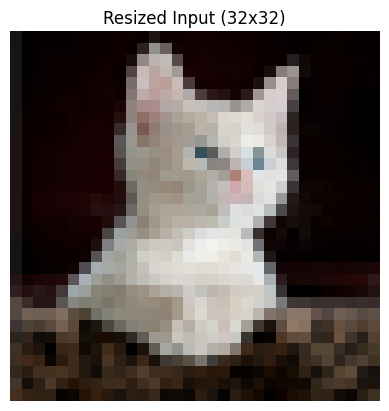

In [13]:
# ============================================================
# 🖼️ MANUAL IMAGE UPLOAD
# ============================================================
from google.colab import files
import io

print("Click 'Choose Files' below and select an image (e.g., a picture of a frog, cat, or car).")
uploaded = files.upload()

# Get the name of the uploaded file
if uploaded:
    uploaded_filename = list(uploaded.keys())[0]

    # Load the image using PIL (Pillow)
    sample_img = Image.open(io.BytesIO(uploaded[uploaded_filename])).convert("RGB")

    # Confirm successful loading
    print(f"\n✅ Successfully loaded '{uploaded_filename}'!")
    print(f"Image size: {sample_img.size}")

    # Display the resized version that the model will use (32x32)
    plt.imshow(sample_img.resize((32, 32)))
    plt.title(f"Resized Input (32x32)")
    plt.axis('off')
    plt.show()

else:
    print("🚨 No file was uploaded. Please try running the cell again.")

--- Initial Prediction for your uploaded image: cat ---
--------------------------------------------------
Scenario A: Distilled Student vs. Strong PGD (ε=0.08)


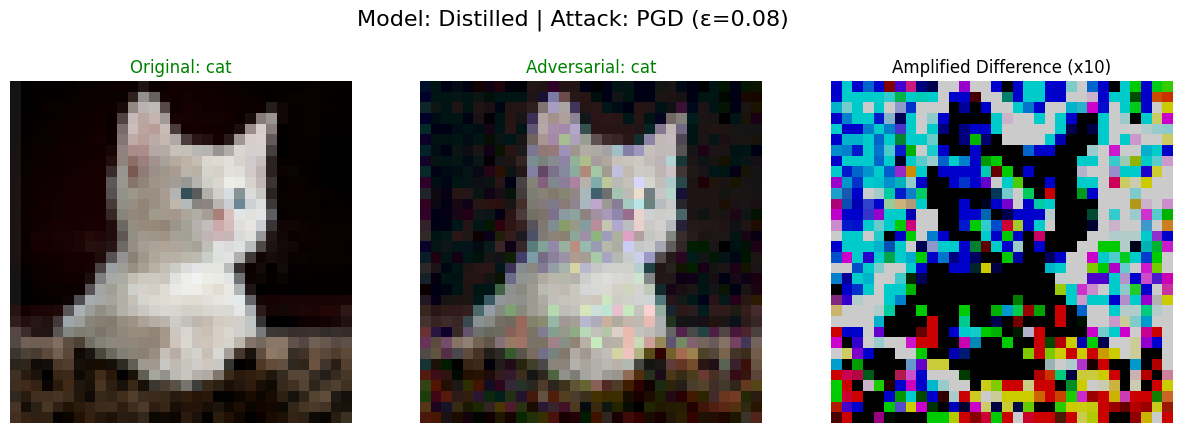


Scenario B: Adversarial Student vs. Strong PGD (ε=0.08)


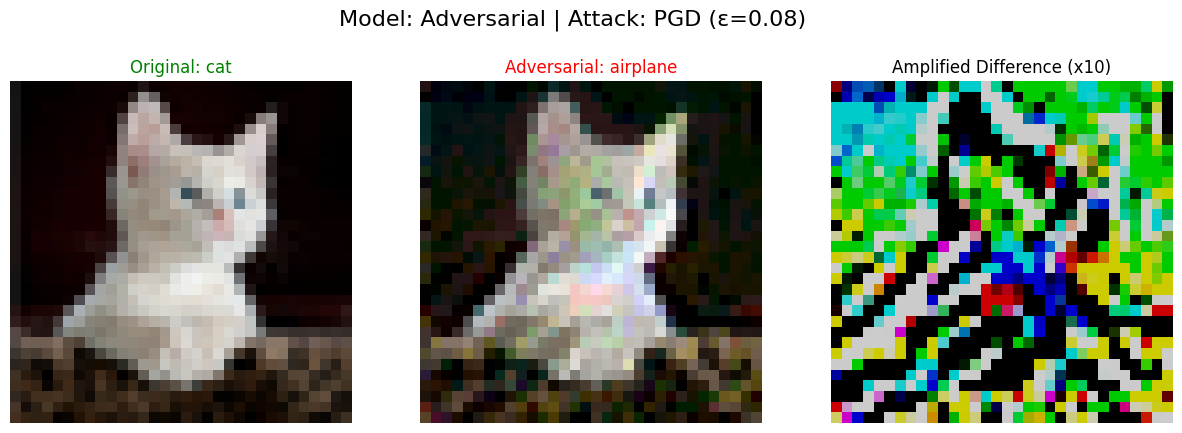


Scenario C: Teacher Model (Clean, No Attack)


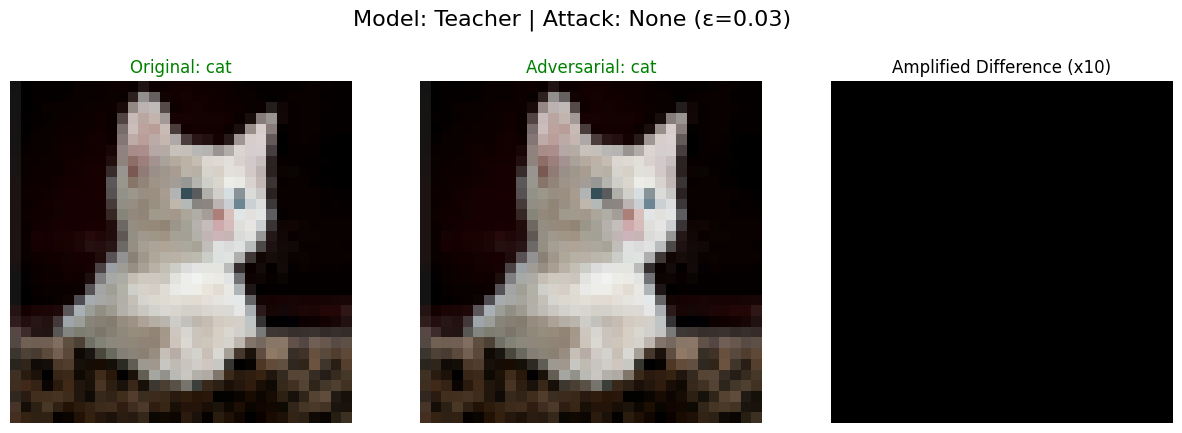

--------------------------------------------------
✅ Project Demonstration Complete!


In [16]:
# ============================================================
# ⚙️ FINAL, FINAL FIX: Direct Script Demonstration (Unnormalization Fixed)
# ============================================================

# Note: All imports and global variables (device, mean, std, classes, fmodel_x, etc.)
# are assumed to be correctly defined in memory from previous cells.

# --- Helper Function Definitions (RE-DEFINED with the fix) ---

def preprocess_image(img: Image):
    """Convert PIL image to normalized torch tensor for CIFAR-10"""
    img = img.resize((32,32))
    img = transforms.ToTensor()(img)
    img = (img.to(device) - mean)/std
    img = img.unsqueeze(0)
    return img

def unnormalize_tensor(tensor):
    """Converts a normalized tensor back to [0, 1] range."""
    if tensor.dim() == 4 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
    # --- FIX APPLIED HERE: DO NOT SQUEEZE mean and std ---
    # The global mean and std are already 3x1x1, which broadcasts correctly.
    return torch.clamp(tensor * std + mean, 0, 1)

# 🔹 Attack function (Final working version)
def generate_adversarial(model_type, attack_type, epsilon, img):

    # Select model
    if model_type=="Teacher":
        fmodel = fmodel_teacher
    elif model_type=="Distilled":
        fmodel = fmodel_student
    else:
        fmodel = fmodel_adv

    model = fmodel._model # Access the PyTorch model

    # Preprocess (Input 'x' is NORMALISED, on device)
    x = preprocess_image(img)

    # 1. Prediction on CLEAN NORMALISED image
    with torch.no_grad():
        logits_clean = model(x)
        y_label_int = logits_clean.argmax(dim=1).item()
        y_label_tensor = torch.tensor([y_label_int]).to(device)
        pred_clean = classes[y_label_int]

    # 2. Prepare UNNORMALISED input for Foolbox attack (on device)
    x_unnorm = unnormalize_tensor(x).unsqueeze(0).to(device)

    # Apply attack
    if attack_type=="None":
        adv_x_unnorm = x_unnorm
    elif attack_type=="FGSM":
        attack = FGSM()
        advs_list, _, _ = attack(fmodel, x_unnorm, y_label_tensor, epsilons=[epsilon])
        adv_x_unnorm = advs_list[0] if advs_list and len(advs_list) > 0 else x_unnorm
    else: # PGD
        attack = PGD(steps=20, rel_stepsize=0.01/epsilon)
        advs_list, _, _ = attack(fmodel, x_unnorm, y_label_tensor, epsilons=[epsilon])
        adv_x_unnorm = advs_list[0] if advs_list and len(advs_list) > 0 else x_unnorm

    # 3. NORMALISED adversarial input for model prediction
    adv_x_pil = transforms.ToPILImage()(adv_x_unnorm.squeeze().cpu())
    adv_x = preprocess_image(adv_x_pil)

    # 4. Prediction on ADVERSARIAL NORMALISED image
    with torch.no_grad():
        logits_adv = model(adv_x)
        pred_adv = classes[logits_adv.argmax(1).item()]

    # Prepare images for display (UNNORMALISED, on CPU for output)
    img_orig = x_unnorm.squeeze().cpu()
    img_adv  = adv_x_unnorm.squeeze().cpu()
    img_diff = torch.clamp((img_adv - img_orig)*10,0,1)

    # Convert tensors to numpy for Matplotlib output
    return img_orig.permute(1,2,0).numpy(), \
           img_adv.permute(1,2,0).numpy(), \
           img_diff.permute(1,2,0).numpy(), \
           pred_clean, \
           pred_adv

# ----------------------------------------------------
# 🧪 RUN SIMULATIONS (Final execution block)
# ----------------------------------------------------
# We need to redefine plot_results since it was defined in a local scope earlier
def plot_results(img_orig, img_adv, img_diff, pred_clean, pred_adv, model_type, attack_type, epsilon):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    title = f"Model: {model_type} | Attack: {attack_type} (ε={epsilon})"
    fig.suptitle(title, fontsize=16)

    axes[0].imshow(img_orig)
    axes[0].set_title(f"Original: {pred_clean}", color='green')
    axes[0].axis('off')

    color = 'red' if pred_adv != pred_clean else 'green'
    axes[1].imshow(img_adv)
    axes[1].set_title(f"Adversarial: {pred_adv}", color=color)
    axes[1].axis('off')

    axes[2].imshow(img_diff)
    axes[2].set_title("Amplified Difference (x10)")
    axes[2].axis('off')

    plt.show()

# --- Check the clean prediction for your uploaded image ---
# NOTE: This line still relies on the old unnormalize_tensor, so we need to run the new one first.
# Re-run the entire simulation block.
print(f"--- Initial Prediction for your uploaded image: {classes[teacher_model(preprocess_image(sample_img)).argmax().item()]} ---")
print("-" * 50)

# Scenario A: Baseline Attack on Distilled Student (should fail)
print("Scenario A: Distilled Student vs. Strong PGD (ε=0.08)")
orig, adv, diff, clean_pred, adv_pred = generate_adversarial(
    model_type="Distilled",
    attack_type="PGD",
    epsilon=0.08,
    img=sample_img
)
plot_results(orig, adv, diff, clean_pred, adv_pred, "Distilled", "PGD", 0.08)

# Scenario B: Robustness Check on Adversarial Student (should succeed)
print("\nScenario B: Adversarial Student vs. Strong PGD (ε=0.08)")
orig, adv, diff, clean_pred, adv_pred = generate_adversarial(
    model_type="Adversarial",
    attack_type="PGD",
    epsilon=0.08,
    img=sample_img
)
plot_results(orig, adv, diff, clean_pred, adv_pred, "Adversarial", "PGD", 0.08)

# Scenario C: Clean Prediction Check on Teacher Model
print("\nScenario C: Teacher Model (Clean, No Attack)")
orig, adv, diff, clean_pred, adv_pred = generate_adversarial(
    model_type="Teacher",
    attack_type="None",
    epsilon=0.03,
    img=sample_img
)
plot_results(orig, adv, diff, clean_pred, adv_pred, "Teacher", "None", 0.03)

print("-" * 50)
print("✅ Project Demonstration Complete!")